In [1]:
%load_ext autoreload  
%autoreload 2  
!hostname  
!pwd  
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "6"
os.environ['JAX_DEBUG_NANS'] = 'True'

isola-h100-1.csail.mit.edu
/vision-nfs/isola/env/akumar01/synthetic-mdps/src
/vision-nfs/isola/env/akumar01/.virtualenvs/dmc/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat
import pickle

In [26]:
import jax
import jax.numpy as jnp
from jax.random import split

import flax
import flax.linen as nn
from flax.training.train_state import TrainState

import optax

In [27]:
from util import load_pkl

In [28]:
from agents.regular_transformer import TrajectoryTransformer

In [193]:
ds = load_pkl("/vision-nfs/isola/env/akumar01/tdmpc_data/", "tdmpc_data_clean")
ds['act'][np.isnan(ds['act'])] = 0.
ds['act'][np.isinf(ds['act'])] = 0.
ds['act'] = ds['act'].clip(-3, 3)
ds['rtg'] = (ds['rew'][..., ::-1].cumsum(axis=-1)[..., ::-1])
ds['done'] = np.zeros(ds['rew'].shape, dtype=bool)
ds['done'][:, :, 0] = True

In [199]:
ds = jax.tree.map(lambda x: jnp.array(x), ds)
ds = jax.tree.map(lambda x: x[0], ds)
ds = jax.tree.map(lambda x: x[-100:], ds)

In [183]:
ctx_len = 1
agent = TrajectoryTransformer(d_obs=24, d_act=6, n_layers=3, n_heads=4, d_embd=128, ctx_len=ctx_len)
@jax.jit
def batch_agent_forward(agent_params, batch):
    # return jax.vmap(agent.apply, in_axes=(None, 0, 0, 0, 0, 0))(agent_params, batch['done'], batch['rtg']/1000, batch['obs'], batch['act'], batch['rew'])
    return jax.vmap(agent.apply, in_axes=(None, 0, 0, 0, 0, 0))(agent_params, None, None, batch['obs'], None, None)

In [143]:
(ds['obs']!=0).sum(axis=-1).max(axis=-1), (ds['act']!=0).sum(axis=-1).max(axis=-1)

(Array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int32),
 Array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32))

In [144]:
# ds['obs'] = (ds['obs']-ds['obs'].mean(axis=(0, 1)))/(ds['obs'].std(axis=(0, 1)))
# ds['act'] = (ds['act']-ds['act'].mean(axis=(0, 1)))/(ds['act'].std(axis=(0, 1)))

In [167]:
jax.tree.map(lambda x: x.shape, ds)

{'act': (100, 500, 6),
 'done': (100, 500),
 'obs': (100, 500, 24),
 'rew': (100, 500),
 'rtg': (100, 500),
 'task': (100, 500)}

In [184]:
def sample_batch(_rng, dataset, batch_size, n_segs, seg_len):
    _rng1, _rng2 = split(_rng)
    N, T, _ = dataset['obs'].shape
    i_e = jax.random.randint(_rng1, (batch_size, 1, 1), minval=0, maxval=N)
    i_t = jax.random.randint(_rng2, (batch_size, n_segs, 1), minval=0, maxval=T - seg_len)
    i_t = i_t + jnp.arange(seg_len)
    batch = jax.tree.map(lambda x: x[i_e, i_t, ...], dataset)
    batch = jax.tree.map(lambda x: rearrange(x, 'b s t ... -> b (s t) ...'), batch)
    return batch
    
def sample_train_batch(_rng):
    _rng1, _rng2 = split(_rng)
    batch = sample_batch(_rng1, ds, 128, 1, ctx_len)
    # batch = data_utils.augment_batch(_rng2, batch, args.n_augs, dist=args.aug_dist)
    return batch

def loss_fn(agent_params, batch):
    result = batch_agent_forward(agent_params, batch)
    act_pred = result['act_pred']
    mse_act = ((result['act_pred'] - batch['act'])**2).mean(axis=-1) # mean over dim
    mse_act = mse_act.mean(axis=0)  # mean over batch
    mse_obs = jnp.zeros_like(mse_act) # TODO: do obs prediction
    loss = mse_act.mean() # mean over ctx
    metrics = dict(loss=loss, mse_act=mse_act, mse_obs=mse_obs)
    return loss, metrics

@jax.jit
def iter_train(train_state, _rng):
    batch = sample_train_batch(_rng)
    (_, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(train_state.params, batch)
    train_state = train_state.apply_gradients(grads=grads)
    return train_state, metrics



In [185]:
rng = jax.random.PRNGKey(0)
rng, _rng = split(rng)

In [186]:

agent_params = agent.init(_rng, jnp.zeros((ctx_len, ), dtype=bool), jnp.zeros((ctx_len, )), jnp.zeros((ctx_len, 24)), jnp.zeros((ctx_len, 6)), jnp.zeros((ctx_len, )))
tx = optax.chain(optax.clip_by_global_norm(1.), optax.adamw(3e-4, weight_decay=0., eps=1e-8))
train_state = TrainState.create(apply_fn=agent.apply, params=agent_params, tx=tx)


In [187]:
train_state, metrics = jax.lax.scan(iter_train, train_state, split(_rng, 10000))

ScopeParamShapeError: Initializer expected to generate shape (24, 128) but got shape (5, 128) instead for parameter "kernel" in "/embed_obs". (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.ScopeParamShapeError)

In [ ]:
((ds['act'][:, :, 0])**2).mean()

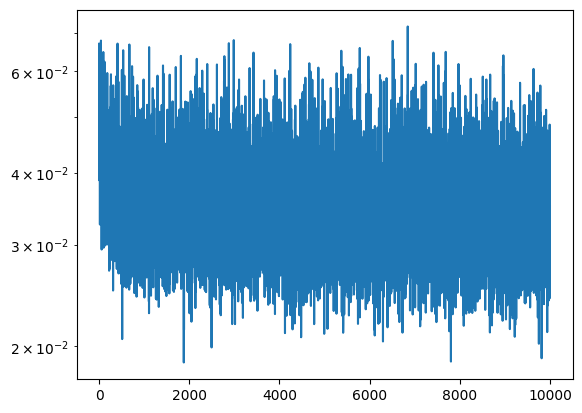

In [150]:
plt.plot(metrics['loss'])
plt.yscale('log')

In [282]:
import gymnasium as gym
from envs.dmcontrol import make_env as make_dm_env

class DMCEnv(gym.Env):
    def __init__(self, task, seed=0):
        self.dm_env = make_dm_env(task, seed=seed)
        o, a = self.dm_env.observation_space, self.dm_env.action_space
        self.observation_space = gym.spaces.Box(o.low, o.high, o.shape, np.float32)
        self.action_space = gym.spaces.Box(a.low, a.high, a.shape, np.float32)
    def reset(self):
        obs = self.dm_env.reset()
        return obs, {}
    def step(self, act):
        obs, rew, done, info = self.dm_env.step(act)
        return obs, rew, done, done, info

class JaxArray(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)

    def reset(self):
        obs, info = self.env.reset()
        obs = jnp.array(obs)
        return obs, info
    def step(self, action):
        obs, rew, term, trunc, info = self.env.step(action)
        obs, rew, term, trunc = jnp.array(obs), jnp.array(rew), jnp.array(term), jnp.array(trunc)
        return obs, rew, term, trunc, info

# class UniversalObs(gym.ObservationWrapper):
#     def __init__(self, env, d_obs):
#         super().__init__(env)
#         self.d_obs = d_obs
#         self.observation_space = gym.spaces.Box(shape=(bs, d_obs,), low=-np.inf, high=np.inf)
#     def observation(self, obs):
#         bs, d_obs_old = obs.shape
#         pad = np.zeros((bs, self.d_obs-d_obs_old), dtype=obs.dtype)
#         obs = np.concatenate([obs, pad], axis=-1)
#         return obs
        
# class UniversalAct(gym.ActionWrapper):
#     def __init__(self, env, d_act):
#         super().__init__(env)
#         self.d_obs_old = env.action_space.shape[-1]
#         self.action_space = gym.spaces.Box(shape=(d_act,), low=-1, high=1)
        
#     def action(self, act):
#         return act[:, :self.d_obs_old]

# env = DMCEnv("cheetah-run", 3)

In [61]:
def rollout(task, ):
    env = gym.vector.SyncVectorEnv([partial(DMCEnv, task, seed) for seed in range(64)])
    # env = UniversalObs(env, 24)
    # env = UniversalAct(env, 6)
    
    env = gym.wrappers.RecordEpisodeStatistics(env)
    print(env.observation_space.shape)
    print(env.action_space.shape)
    
    buffer = dict(obs=[], act=[], rew=[], done=[])
    stats = []
    
    obs, infos = env.reset()
    for _ in tqdm(range(500), desc="Rollout"):
        
        act = env.action_space.sample()
        obs, rew, term, trunc, infos = env.step(act)

        if "episode" in infos:
            for r, l in zip(infos['episode']['r'], infos['episode']['l']):
                stats.append((r, l))
    stats = np.array(stats)
    return stats

stats = rollout('cheetah-run')

(64, 17)
(64, 6)


Rollout:   0%|          | 0/500 [00:00<?, ?it/s]

In [21]:
stats[:, 0].mean(), stats[: ,0].std()

(0.12857014237670228, 0.0651522142017685)

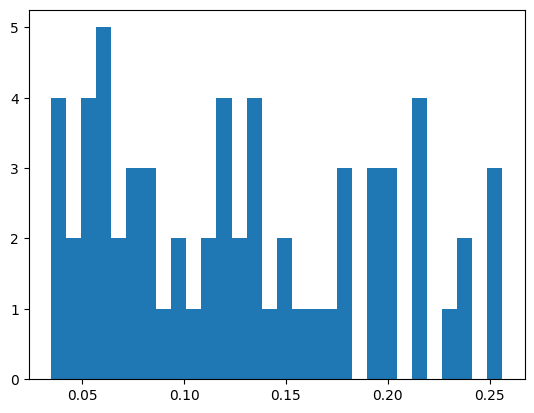

In [22]:
plt.hist(stats[:, 0], bins=30);

In [152]:
def rollout(task, n_envs, agent, agent_params, prompt=None):
    env = gym.vector.SyncVectorEnv([partial(DMCEnv, task, seed) for seed in range(n_envs)])
    env = gym.wrappers.RecordEpisodeStatistics(env)
    env = JaxArray(env)
    
    print(env.observation_space.shape)
    print(env.action_space.shape)
    d_obs, d_act = env.observation_space.shape[-1], env.action_space.shape[-1]

    def transform_obs(obs):
        bs, d = obs.shape
        pad = jnp.zeros((bs, agent.d_obs-d_obs), dtype=obs.dtype)
        obs = jnp.concatenate([obs, pad], axis=-1)
        return obs
        
    def inv_transform_act(act):
        d_act = env.action_space.shape[-1]
        return act[:, :d_act]

    ctx_len = agent.ctx_len
    def get_action(buffer):
        buffer = {k: jnp.stack(v[-ctx_len:], axis=1) for k, v in buffer.items()}
        _, buf_len, _ = buffer['obs'].shape
        prompt_len = 0
        pad_len = ctx_len - buf_len
        pad_buffer = {k: repeat(v[:, 0, ...], "N ... -> N pad_len ...", pad_len=pad_len) for k, v in buffer.items()}
        # inputs = {k: jnp.concatenate([prompt[k], buffer[k], pad_buffer[k]], axis=1) for k in buffer}
        inputs = {k: jnp.concatenate([buffer[k], pad_buffer[k]], axis=1) for k in buffer}
        outputs = batch_agent_forward(agent_params, inputs)
        return outputs['act_pred'][:, prompt_len+buf_len-1, :]
        
    stats = []
    buffer = dict(done=[], rtg=[], obs=[], act=[], rew=[])
    
    rtg = jnp.ones((n_envs, ))*1000
    (obs, infos), done = env.reset(), jnp.ones((n_envs, ), dtype=bool)
    act = jnp.zeros((n_envs, d_act))
    rew = jnp.zeros((n_envs, ))
    
    for _ in tqdm(range(500), desc="Rollout"):
        buffer['done'].append(done)
        buffer['rtg'].append(rtg)
        buffer['obs'].append(transform_obs(obs))
        buffer['act'].append(act) # dummy
        buffer['rew'].append(rew) # dummy

        if agent_params is None:
            act = env.action_space.sample()
        else:
            act = np.array(inv_transform_act(get_action(buffer)))
        
        obs, rew, term, trunc, infos = env.step(act)
        done = term | trunc

        buffer['act'][-1] = act
        buffer['rew'][-1] = rew
        rtg = rtg - rew

        if "episode" in infos:
            for r, l in zip(infos['episode']['r'], infos['episode']['l']):
                stats.append((r, l))
    stats = np.array(stats)
    
    buffer = {k: jnp.stack(v, axis=1) for k, v in buffer.items()}
    return stats, buffer

In [161]:
stats1, buffer1 = rollout('cartpole-balance-sparse', 32, agent, None, None)
stats2, buffer2 = rollout('cartpole-balance-sparse', 32, agent, train_state.params, None)

(32, 5)
(32, 1)


Rollout:   0%|          | 0/500 [00:00<?, ?it/s]

(32, 5)
(32, 1)


Rollout:   0%|          | 0/500 [00:00<?, ?it/s]

In [162]:
print(stats1[:, 0].mean())
print(stats2[:, 0].mean())

44.375
27.78125


In [372]:
buffer2['obs'].shape

(32, 500, 24)

In [373]:
ds['obs'].shape

(10, 500, 24)

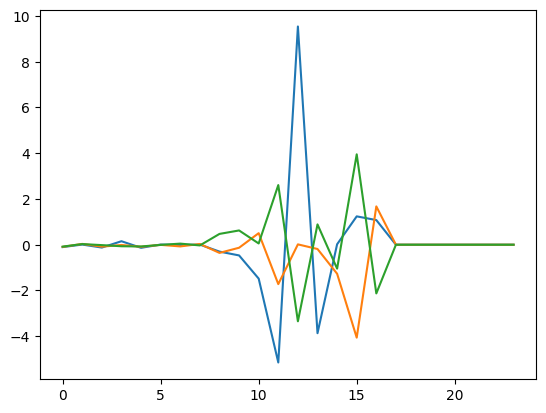

In [377]:
plt.plot(ds['obs'][-1, 1, :])
plt.plot(buffer1['obs'][-1, 1, :])
plt.plot(buffer2['obs'][-1, 1, :])

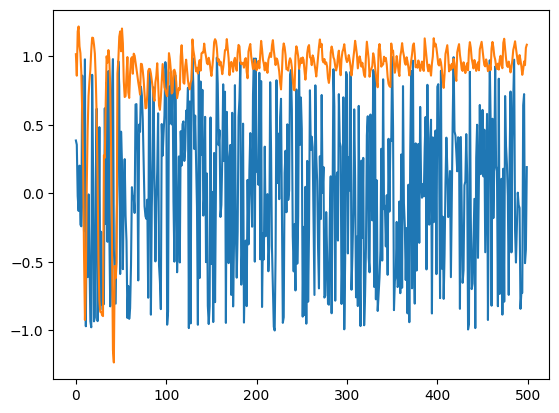

In [169]:
plt.plot(np.stack(buffer1['act'], axis=1)[0, :, 0])
plt.plot(np.stack(buffer2['act'], axis=1)[0, :, 0])

In [144]:
buffer1['act'][0][0, 0]

-0.06935599

In [145]:
buffer2['act'][0][0, 0]

Array(0.78859407, dtype=float32)

In [132]:
stats[:, 0].mean()

0.12902958132326603

In [120]:
stats[:, 0].mean()

0.12902958132326603

In [32]:
from dm_control import suite

In [ ]:
Acrobot Swingup	6	1
Cartpole Balance	5	1
Cartpole Balance Sparse	5	1
Cartpole Swingup	5	1
Cartpole Swingup Sparse	5	1
Cheetah Jump	17	6
Cheetah Run	17	6
Cheetah Run Back	17	6
Cheetah Run Backwards	17	6
Cheetah Run Front	17	6
Cup Catch	8	2
Cup Spin	8	2
Finger Spin	9	2
Finger Turn Easy	12	2
Finger Turn Hard	12	2
Fish Swim	24	5
Hopper Hop	15	4
Hopper Hop Backwards	15	4
Hopper Stand	15	4
Pendulum Spin	3	1
Pendulum Swingup	3	1
Reacher Easy	6	2
Reacher Hard	6	2
Reacher Three Easy	8	3
Reacher Three Hard	8	3
Walker Run	24	6
Walker Run Backwards	24	6
Walker Stand	24	6
Walker Walk	24	6
Walker Walk Backwards	24

In [231]:
ds_obs, ds_act = ds['obs'][..., :6].reshape(-1, 6), ds['act'][..., :1].reshape(-1, 1)

In [237]:
ds['rtg'][:, 0].mean()

Array(886.26685, dtype=float32)

In [257]:
print(ds_obs.mean(axis=0))
print(ds_obs.std(axis=0))
print(ds_act.mean(axis=0))
print(ds_act.std(axis=0))

[ 3.7587233e-04 -1.2826889e-03  8.3923453e-01  9.2030108e-01
 -1.3637548e-02 -3.4041531e-02]
[0.29199952 0.27748746 0.45871726 0.2757626  1.6521945  3.0600073 ]
[-0.00570193]
[0.6780561]


In [269]:
class MLP(nn.Module):
    d_act: int
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=32)(x)
        x = nn.gelu(x)
        x = nn.Dense(features=32)(x)
        x = nn.gelu(x)
        x = nn.Dense(features=32)(x)
        x = nn.gelu(x)
        x = nn.Dense(features=self.d_act)(x)
        return x

rng = jax.random.PRNGKey(0)

mlp = MLP(1)
rng, _rng = split(rng)
params = mlp.init(_rng, jnp.ones(6,))
tx = optax.adam(3e-4)
train_state = TrainState.create(apply_fn=mlp.apply, params=params, tx=tx)

In [270]:
def loss_fn(params, obs, act):
    act_pred = jax.vmap(mlp.apply, in_axes=(None, 0))(params, obs)
    loss = ((act_pred-act)**2).mean()
    return loss
    
@jax.jit
def train_step(state, rng):
    idx = jax.random.randint(rng, (256, ), 0, 50000)
    obs, act = ds_obs[idx], ds_act[idx]
    (loss, grads) = jax.value_and_grad(loss_fn)(state.params, obs, act)
    return state.apply_gradients(grads=grads), loss


train_state, losses = jax.lax.scan(train_step, train_state, split(_rng, 1000000))


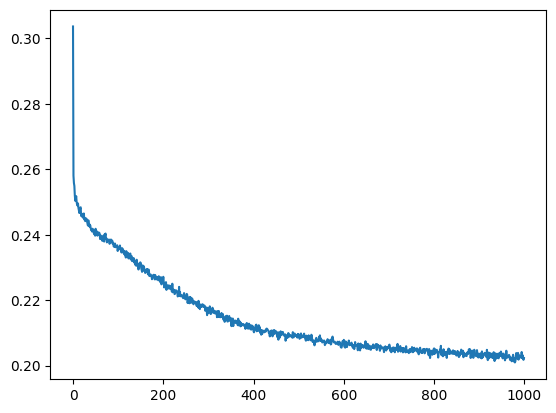

In [279]:
plt.plot(losses.reshape(-1, 1000).mean(axis=-1))
# plt.yscale('log')

In [305]:
params = train_state.params
agent_forward = partial(jax.jit(jax.vmap(mlp.apply, in_axes=(None, 0))), params)

In [313]:
env = gym.vector.SyncVectorEnv([partial(DMCEnv, "acrobot-swingup", seed) for seed in range(64)])
env = gym.wrappers.RecordEpisodeStatistics(env)

In [314]:
obs, info = env.reset()
for t in tqdm(range(500)):
    act = agent_forward(obs)
    act = np.array(act)
    # act = env.action_space.sample()
    # act.shape
    obs, rew, term, trunc, infos = env.step(act)    

  0%|          | 0/500 [00:00<?, ?it/s]

In [315]:
infos['episode']['r'].mean()

16.63522

In [343]:
obs.shape

(100, 6)

<ErrorbarContainer object of 3 artists>

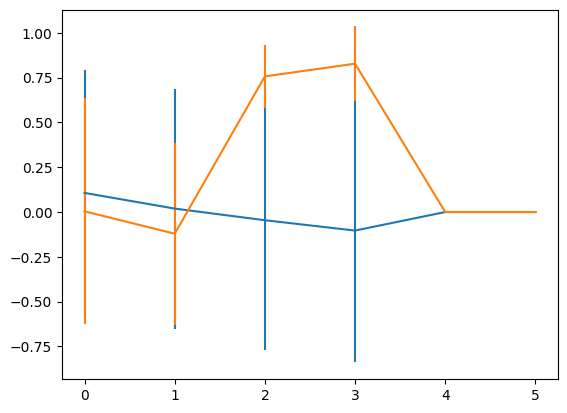

In [344]:
obs, info = env.reset()
plt.errorbar(np.arange(6), obs.mean(axis=0), obs.std(axis=0))
obs = ds_obs.reshape(100, 500, 6)[:, 0]
plt.errorbar(np.arange(6), obs.mean(axis=0), obs.std(axis=0))
